# 使用自动标注的数据训练快速过滤器

In [1]:
#!AHOCORASICK_BYTES=1 pip install git+https://github.com/WojciechMula/pyahocorasick.git

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random
from tokenizer import tokenizer,token2str,vocab_size
import torch
import torch.nn as nn
from make_model import make_model
from train_and_use import Batch,CrossEntropyLoss,SimpleAdamOptimizer,OptimizerWrapper,train_server_start
from train_and_use import text_continue
from train_and_use import TOGGLE,STOP
from train_and_use import record
from collections import Counter,defaultdict
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# %matplotlib widget

In [3]:
model = make_model(
    #token是从1开始的，0填充，剩下的用来覆盖全部字节
    vocab_size = vocab_size+1+255,
    embedding_dim = 16,
    key_dim = 8,
    head_number = 2,
    position_information_type = "mask",
    # position_information_type = "sinusoidal",
    # position_information_type = "rotary",
    # position_information_type = "learned",
    enable_affine = True,
    enable_talking_head = False,
    use_diff = False,
    self_attention_block_size = 0,
    feed_forward_dim = 16,
    enable_layer_norm = True,
    deep = 1,
    dropout_rate = 0.1
).to(device)

In [4]:
lines = []
with open('low_auto.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：低') for line in f if len(line) > 16]
    lines += random.sample(temp,55000)
with open('mid_auto.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：中') for line in f if len(line) > 16]
    lines += random.sample(temp,55000)
with open('high_auto.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：高') for line in f if len(line) > 16]
    lines += random.sample(temp,55000)

In [5]:
def data_generator(batch_size):
    #将各等级的数据打乱
    np.random.shuffle(lines)
    for i in range(0,len(lines),batch_size):
        data = [tokenizer(line[0],1.0) for line in lines[i:i+batch_size]]
        label = [tokenizer(line[1],5.0) for line in lines[i:i+batch_size]]
        trunk = [(s + [-255]*1000)[:1000]+l for s,l in zip(data,label)]
        trunk = np.array(trunk,dtype=np.int64)+255
        inputs = torch.from_numpy(trunk).to(device).data
        ret = Batch(inputs)
        ret.label = ret.label.clone()
        #只预测最后的标签
        ret.label[:,:-1] = 0
        ret.ntokens = ret.label.size(0)
        yield ret

In [6]:
# model.load_state_dict(torch.load('large_model_2.907_.weight',weights_only=True))
model.train()
loss_f = CrossEntropyLoss()
optimizer = OptimizerWrapper(
    optimizer = SimpleAdamOptimizer(model.parameters(),betas = (0.9,0.98),eps = 1e-7),
    warm_up = 200,
    lr = 3e-5
)
split_n    = 48#资源不够时，累积梯度的方式模拟大批次
batch_size = split_n * 6
train_server_start(model,(data_generator,batch_size),split_n,loss_f,optimizer,use_amp = True)

epoch: 3 	step: 281 	loss: 0.360 	speed: 50.5074 tokens/s                    

In [23]:
TOGGLE()
# STOP()

pause: True


In [8]:
# optimizer.set_lrate(1e-5,480)

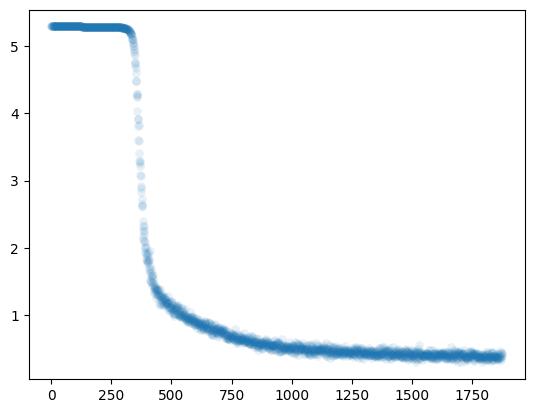

In [22]:
plt.close()
plt.scatter(list(range(len(record['loss_line']))),record['loss_line'],alpha=0.1,linewidths=0.1)
# plt.plot(record['loss_line'])
plt.show()

In [10]:
# plt.close()
# # plt.plot(record['loss_line'])
# plt.plot(record['lr_line'])
# plt.show()

In [24]:
# torch.save(model.state_dict(),'fastautotagger.weight')